# RFM 기반 Fraud 탐지 

본 분석에서는 고객 행동 분석 기법인 RFM(Recency, Frequency, Monetary)을 활용하여  
모바일 금융 거래 시뮬레이션 데이터셋(PaySim)에서 사기(Fraud) 패턴을 탐색하고자 한다.  

## 1. RFM 분석론
RFM은 고객 데이터를 요약하고 세분화하기 위한 전통적인 분석 방법으로,  
마케팅, CRM, 리텐션 관리 등 다양한 분야에서 활용된다.  
핵심은 고객을 단순한 매출액 기준이 아니라 **행동 특성**을 기준으로 나누는 것이다.  

- **Recency (최신성)**  
  - 고객이 마지막으로 거래한 시점이 얼마나 최근인지 측정한다.  
  - 값이 작을수록 최근에 활동했음을 의미하며, 재참여 가능성이 높다고 본다.  

- **Frequency (빈도)**  
  - 일정 기간 동안 고객이 몇 번이나 거래했는지 나타낸다.  
  - 빈도가 높을수록 서비스 충성도가 높고, 정상적인 활동일 가능성이 크다.  
  - 하지만 Fraud 탐지 관점에서는 단기간 과도한 빈도가 위험 신호가 될 수 있다.  

- **Monetary (금액)**  
  - 고객이 일정 기간 동안 지출한 총액.  
  - 금액이 클수록 고가치 고객으로 분류되지만,  
    비정상적으로 큰 금액의 전송은 사기 거래의 주요 특징이 될 수 있다.  

즉, RFM 분석은 **최근성·빈도·금액이라는 세 가지 축**을 통해 고객군을 분류하고,  
이를 기반으로 행동 패턴을 이해하고 위험 신호를 식별하는 방법론이다.  

## 2. PaySim 데이터셋에서의 활용
PaySim에서는 송신자(`nameOrig`)를 고객 단위로 정의하고, 각 계정의 거래 이력을 기반으로 RFM 값을 계산한다.  
- **Recency** → `MAX(step)`을 기준으로 마지막 거래 시점과의 차이  
- **Frequency** → 고객별 거래 횟수  
- **Monetary** → 고객별 거래 금액 합계  

이렇게 산출한 RFM 지표를 Fraud 여부(`isFraud`)와 비교하여,  
사기 계정이 어떤 거래 특성을 가지는지 탐지한다.

## 3. 분석 방법
1. 전체 거래 현황 파악 (거래 수, Fraud 수, Fraud 비율)  
2. 고객 단위 RFM 값 산출  
3. Recency / Frequency / Monetary 구간별 세그먼트 설정  
4. 각 세그먼트별 Fraud 분포 비교  
5. RFM 점수화 및 가중치 기반 위험군 분류  

이 과정을 통해 PaySim 데이터 내에서 Fraud 계정이 가지는 RFM 특성을 체계적으로 분석한다.


In [8]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text

user = 'root'
password = 'doyeon5345'
host = 'localhost'
port = 3306
db = 'paysim'

try:
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')
    print("MySQL 연결 성공")
except Exception as e:
    print("연결 실패:", e)


MySQL 연결 성공


In [9]:
# 전체 거래 수, Fraud 거래 수, Fraud 비율, Fraud 금액 비중
# Fraud가 전체 거래 중 몇 %이고, 금액 기준으로는 몇 %인지 확인
query = """
SELECT
    COUNT(*) AS total_txn,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS fraud_txn,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_txn_rate,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END) / SUM(amount), 2) AS fraud_amount_rate
FROM paysim;
"""

df_result = pd.read_sql(query, engine)
print(df_result)

   total_txn  fraud_txn  fraud_txn_rate  fraud_amount_rate
0     114957      171.0            0.15               1.05


거래 건수 대비 사기 비율은 **0.15%**로 낮지만, 금액 기준 비율은 1% 이상으로 상대적으로 높음.
→ 소수의 고액 거래에서 사기가 발생.

In [10]:
# 고객 단위 RFM 값 산출
# - recency: 마지막 거래 이후 경과 step
# - frequency: 거래 횟수
# - monetary: 총 거래 금액
# - fraud_amount: Fraud 거래 금액 합계
# - has_fraud: Fraud 경험 여부(1/0)
query_rfm_base = """
WITH rfm_base AS (
    SELECT
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END) AS fraud_amount,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim
    GROUP BY nameOrig
)
SELECT * FROM rfm_base LIMIT 10;
"""

df_rfm_base = pd.read_sql(query_rfm_base, engine)
print(df_rfm_base.head())


   customer_id  recency  frequency    monetary  fraud_amount  has_fraud
0   C632336343      528          1   330218.42           0.0          0
1  C1264712553      791          1    11647.08           0.0          0
2  C1746846248      796          1   152264.21           0.0          0
3   C333676753      403          1  1551760.63           0.0          0
4   C813403091      600          1    78172.30           0.0          0


In [11]:
# Recency 세그먼트 분석 
# step = 1시간 단위
# 구간: 최근24h, 최근3일, 최근1주, 최근2주, 최근1개월, 휴면

query_recency_segment = """
WITH recency_segments AS (
    SELECT
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud,
        CASE
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 24  THEN '1_최근24h'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 72  THEN '2_최근3일'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 168 THEN '3_최근1주'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 336 THEN '4_최근2주'
            WHEN (SELECT MAX(step) FROM paysim) - MAX(step) <= 744 THEN '5_최근1개월'
            ELSE '6_휴면'
        END AS recency_group
    FROM paysim
    GROUP BY nameOrig
)
SELECT 
    recency_group,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM recency_segments
GROUP BY recency_group
ORDER BY fraud_rate DESC;
"""
with engine.connect() as conn:
    df_recency = pd.read_sql(text(query_recency_segment), conn)
print("Recency:\n", df_recency)


Recency:
   recency_group  customers  fraud_customers  fraud_rate
0        2_최근3일         37              2.0        5.41
1        3_최근1주       1391             23.0        1.65
2        4_최근2주       4148             27.0        0.65
3          6_휴면      15390             15.0        0.10
4       5_최근1개월      79017             74.0        0.09
5       1_최근24h         16              0.0        0.00


## Recency 세그먼트 결과 해석

Fraud율은 **최근3일(5.41%) > 최근1주(1.65%) > 최근2주(0.65%) > 휴면(0.10%) > 최근1개월(0.09%) > 최근24h(0.00%)** 순으로 나타났다.  
즉, **최근에 거래한 계정일수록 Fraud 발생 가능성이 높다.**

- **최근3일 이내 거래 그룹**: Fraud율이 5%를 넘으며 가장 높다.  
  사기 계정이 단기간에 집중적으로 활동하는 특성이 반영된 결과다.  
- **최근1주~2주 그룹**: 여전히 Fraud율이 높게 유지되며, 사기 행위가 특정 기간에 몰리는 경향이 보인다.  
- **휴면·최근1개월 이상 그룹**: Fraud율이 매우 낮으며, 정상 사용자의 장기 비활동 패턴으로 해석된다.  
- **최근24시간 그룹**: 표본 수가 적어 유의미한 판단은 어렵다.

결과적으로, PaySim에서는 **활동이 최근일수록 사기 위험이 급격히 증가**하는 경향이 있으며, Fraud 탐지 시 ‘최근 거래 빈도’는 핵심적인 위험 지표로 활용 가능하다.

In [12]:
# Frequency 세그먼트 분석
# 구간: 1회, 2~3회, 4~10회, 11~50회, 50회 초과

query_frequency_segment = """
WITH freq_txn AS (
    SELECT
        nameOrig AS customer_id,
        COUNT(*) AS txn_count,
        CASE
            WHEN COUNT(*) = 1 THEN '1_단발성'
            WHEN COUNT(*) BETWEEN 2 AND 3 THEN '2_저빈도'
            WHEN COUNT(*) BETWEEN 4 AND 10 THEN '3_중빈도'
            WHEN COUNT(*) BETWEEN 11 AND 50 THEN '4_고빈도'
            ELSE '5_초고빈도'
        END AS freq_group
    FROM paysim
    GROUP BY nameOrig
),
joined AS (
    SELECT p.*, f.freq_group
    FROM paysim p
    JOIN freq_txn f ON p.nameOrig = f.customer_id
)
SELECT
    freq_group,
    COUNT(*) AS total_txn,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS fraud_txn,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) / COUNT(*), 3) AS fraud_rate
FROM joined
GROUP BY freq_group
ORDER BY fraud_rate DESC;

"""
with engine.connect() as conn:
    df_frequency = pd.read_sql(text(query_frequency_segment), conn)
print("Frequency:\n", df_frequency)

Frequency:
   freq_group  total_txn  fraud_txn  fraud_rate
0      3_중빈도      14895       31.0       0.208
1      2_저빈도       5063        9.0       0.178
2      1_단발성      94999      131.0       0.138


## Frequency 세그먼트 결과 해석

Fraud율은 **중빈도(0.208%) > 저빈도(0.178%) > 단발성(0.138%)** 순으로 나타났다.  
즉, 단 한 번 거래한 계정보다 **반복 거래를 수행한 계정에서 사기 발생 가능성이 높다.**

- **중빈도 (4~10회)**: Fraud율이 가장 높으며, 사기 계정이 여러 건의 거래 후 인출(CASH_OUT)을 시도하는 경향과 일치.  
- **저빈도 (2~3회)**: 소액 테스트 후 실제 사기를 시도하는 탐색형 거래로 해석 가능.  
- **단발성 (1회)**: 거래 수는 많지만 대부분 정상 거래로 구성되어 Fraud율이 낮음.

결과적으로, PaySim에서는 **반복 거래형 계정이 단발 거래형보다 Fraud 위험이 높다.**

In [13]:
# Monetary 세그먼트 분석 
# 구간: <10K, 10K~100K, 100K~500K, 500K~1M, 1M 이상

query_monetary_segment = """
WITH monetary_segments AS (
    SELECT
        nameOrig AS customer_id,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud,
        CASE
            WHEN SUM(amount) < 10000 THEN '1_소액(<10K)'
            WHEN SUM(amount) < 100000 THEN '2_중소액(10K~100K)'
            WHEN SUM(amount) < 500000 THEN '3_중액(100K~500K)'
            WHEN SUM(amount) < 1000000 THEN '4_고액(500K~1M)'
            ELSE '5_초고액(1M+)'
        END AS monetary_group
    FROM paysim
    GROUP BY nameOrig
)
SELECT 
    monetary_group,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM monetary_segments
GROUP BY monetary_group
ORDER BY fraud_rate DESC;
"""


with engine.connect() as conn:
    df_monetary = pd.read_sql(text(query_monetary_segment), conn)

print("Monetary:\n", df_monetary)


Monetary:
     monetary_group  customers  fraud_customers  fraud_rate
0       5_초고액(1M+)       2976             53.0        1.78
1    4_고액(500K~1M)       4168             25.0        0.60
2  3_중액(100K~500K)      38648             30.0        0.08
3  2_중소액(10K~100K)      34779             28.0        0.08
4       1_소액(<10K)      19428              5.0        0.03


## Monetary 세그먼트 결과 해석

Fraud율은 **초고액(1M+) 1.78% > 고액(500K~1M) 0.60% > 중·소액 이하 0.08% 이하**로 나타났다.  
즉, 거래 금액이 커질수록 사기 발생 가능성이 뚜렷하게 증가한다.

- **초고액 (1M+)**: Fraud율이 가장 높으며, 소수의 고액 거래에서 사기가 집중 발생.  
  사기 계정이 한 번에 큰 금액을 이체·인출하려는 경향을 보인다.  
- **고액 (500K~1M)**: 두 번째로 높은 Fraud율을 보여, 일정 금액 이상 거래는 고위험군으로 분류 가능.  
- **중·소액(≤500K)**: 거래 수는 많지만 대부분 정상 거래로 구성되어 Fraud율이 매우 낮다.

결과적으로, PaySim에서는 **거래 금액이 클수록 Fraud 발생 확률이 높아지는 고액 집중형 패턴**이 확인된다.

In [14]:
# RFM 기반 고객 세그먼트 (VIP / 일반 / 위험)
# - Recency: 최근일수록 높은 점수
# - Frequency: 거래 잦을수록 높은 점수
# - Monetary: 거래 금액 클수록 높은 점수
# - NTILE(5)로 각각 1~5 점수 부여
# - 가중치: R=0.3, F=0.4, M=0.3
# - 고객 유형 분류: VIP(4.0 이상), 일반(2.5~3.9), 위험(2.5 미만)

query_rfm_segment = """
WITH rfm_base AS (
    SELECT
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim
    GROUP BY nameOrig
),
scored AS (
    SELECT
        customer_id,
        recency,
        frequency,
        monetary,
        has_fraud,
        NTILE(5) OVER (ORDER BY recency ASC)  AS R_score,  -- recency 낮을수록 점수 높음
        NTILE(5) OVER (ORDER BY frequency DESC) AS F_score, -- 거래 많을수록 점수 높음
        NTILE(5) OVER (ORDER BY monetary DESC)  AS M_score  -- 금액 클수록 점수 높음
    FROM rfm_base
),
weighted AS (
    SELECT *,
           ROUND(R_score*0.3 + F_score*0.4 + M_score*0.3, 2) AS rfm_weighted
    FROM scored
)
SELECT
    CASE
        WHEN rfm_weighted >= 4.0 THEN 'VIP'
        WHEN rfm_weighted BETWEEN 2.5 AND 3.9 THEN '일반'
        ELSE '위험'
    END AS customer_type,
    COUNT(*) AS customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM weighted
GROUP BY customer_type
ORDER BY fraud_rate DESC;
"""

with engine.connect() as conn:
    df_rfm_segment = pd.read_sql(text(query_rfm_segment), conn)

print(df_rfm_segment)

  customer_type  customers  fraud_customers  fraud_rate
0            위험      25428             87.0        0.34
1            일반      60779             52.0        0.09
2           VIP      13792              2.0        0.01


## RFM 가중치 설정 근거

RFM 점수의 종합 가중치는 `R=0.3`, `F=0.4`, `M=0.3`으로 설정하였다.  
이는 Fraud 탐지 목적에 맞춰 각 지표가 가지는 상대적 중요도를 반영한 결과이다.

| 지표 | 가중치 | 설명 |
|------|---------|------|
| Recency | 0.3 | 사용자의 마지막 거래 이후 경과 시간. 최근 거래가 많을수록 Fraud 위험 신호가 될 수 있으나, 단독 지표로는 판단이 어려움. 중간 수준의 비중을 부여. |
| Frequency | 0.4 | 일정 기간 내 거래 횟수. 짧은 시간 안에 비정상적으로 많은 거래를 발생시키는 패턴은 사기의 주요 특성으로, 세 지표 중 가장 높은 중요도로 반영. |
| Monetary | 0.3 | 총 거래 금액. Fraud 거래는 대체로 고액 전송 형태를 띠지만, 모든 고액 거래가 사기는 아니므로 과도한 편향을 방지하기 위해 중간 수준으로 조정. |

따라서 본 분석에서는 **거래 빈도(Frequency)** 를 핵심 변수로 두되, **거래 시점(Recency)** 과 **거래 금액(Monetary)** 의 영향도 균형 있게 반영하였다.  
이 비율(0.3:0.4:0.3)은 Fraud 탐지에서 **행동량 중심의 위험 평가 모델**로 적합한 조합이다.

## 고객 유형 분류 기준

RFM 가중합 점수(`rfm_weighted`)를 기준으로 고객을 세 가지 유형으로 분류하였다.  
이 구분은 각 사용자의 활동 패턴과 거래 규모를 종합적으로 반영하여  
고객의 **가치 수준과 잠재적 위험도**를 파악하기 위함이다.

| 고객 유형 | 기준 (rfm_weighted) | 특징 |
|------------|---------------------|------|
| **VIP 고객** | ≥ 4.0 | 거래가 활발하고 금액이 크며, 최근 활동이 잦은 상위 그룹. 일반적으로 가치가 높은 핵심 고객군으로 간주되지만, Fraud 탐지 관점에서는 대규모 자금 이동이 잦은 만큼 정밀 모니터링 필요. |
| **일반 고객** | 2.5 ~ 3.9 | 평균 수준의 활동성과 금액 규모를 보이는 다수의 정상 사용자 그룹. Fraud 비율이 낮고 안정적인 거래 패턴을 가진다. |
| **위험 고객** | < 2.5 | 거래가 드물거나 비정상적 주기를 가진 계정. 활동 빈도나 금액이 낮아 비활성화된 계정이 포함되지만, 일부 Fraud 계정이 잠시 활동 후 사라지는 경우도 있어 위험군으로 분류. |

이 세분화는 RFM 점수를 단순한 수치가 아니라  **행동 패턴별 위험도 구간**으로 해석하기 위한 절차이다.  

Fraud 탐지에서는 특히 **위험 고객군**의 거래 양상을 분석하고,  **VIP 고객군**의 대규모 거래 중 이상 패턴을 추가 점검하는 방식으로 활용할 수 있다.

## RFM 세그먼트 결과 해석

분석 결과, 고객의 RFM 등급이 낮을수록 사기 거래 비율이 뚜렷하게 높게 나타났다.  
위험군은 전체 고객 중 약 25%를 차지하지만, 전체 사기 거래의 절반 이상이 이 그룹에서 발생했다.  
반면 VIP 그룹은 전체의 약 14% 수준임에도 Fraud 발생은 극히 드물었다.

사기율은 위험군(0.34%) > 일반군(0.09%) > VIP군(0.01%) 순으로 급격히 감소하였다.  
이는 RFM 점수가 고객의 거래 안정성과 밀접하게 연관되어 있음을 보여준다.  
즉, 거래 빈도가 낮고 금액 규모가 불규칙하며 최근 거래가 뜸한 사용자가 상대적으로 높은 Fraud 위험도를 보이는 경향이 있다.

요약하면, RFM 기반 세분화는 Fraud 탐지에 유효한 위험 구분 기준으로 작동한다.  
위험군은 집중 모니터링 대상이며, 일반군은 기준선(normal baseline), VIP군은 안정적인 고가치 고객으로 판단된다.  

In [15]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 깨짐 방지 (macOS 예시)
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

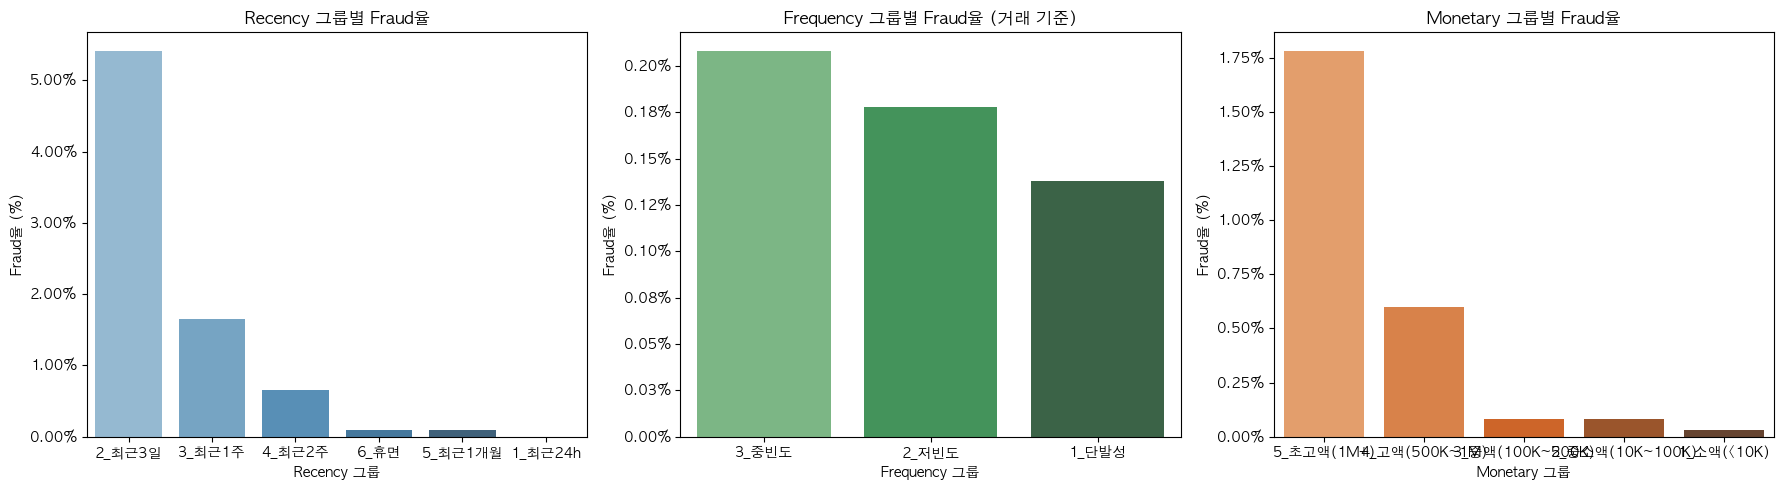

In [17]:
# Recency / Frequency / Monetary 세그먼트별 Fraud율 비교 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.barplot(
    data=df_recency,
    x="recency_group",
    y="fraud_rate",
    ax=axes[0],
    palette="Blues_d"
)
axes[0].set_title("Recency 그룹별 Fraud율")
axes[0].set_xlabel("Recency 그룹")
axes[0].set_ylabel("Fraud율 (%)")
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}%"))

# Frequency
sns.barplot(
    data=df_frequency,
    x="freq_group",     # 수정됨 (기존 frequency_group → freq_group)
    y="fraud_rate",
    ax=axes[1],
    palette="Greens_d"
)
axes[1].set_title("Frequency 그룹별 Fraud율 (거래 기준)")
axes[1].set_xlabel("Frequency 그룹")
axes[1].set_ylabel("Fraud율 (%)")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}%"))

# Monetary
sns.barplot(
    data=df_monetary,
    x="monetary_group",
    y="fraud_rate",
    ax=axes[2],
    palette="Oranges_d"
)
axes[2].set_title("Monetary 그룹별 Fraud율")
axes[2].set_xlabel("Monetary 그룹")
axes[2].set_ylabel("Fraud율 (%)")
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}%"))

plt.tight_layout()
plt.show()


Recency: 최근 3일 이내 활동 고객에서 Fraud율이 가장 높음(5% 이상). 시간이 지날수록 Fraud율이 급격히 감소 → 신규·활성 고객군에서 사기 발생 위험이 크다는 의미.

Frequency: 거래 횟수가 중간 정도인 고객군(4~10회)에서 Fraud율이 가장 높음. 단발성 고객보다 오히려 일정 빈도를 가진 그룹이 사기에 더 노출됨.

Monetary: 거래 금액이 큰 고객일수록 Fraud율이 높아짐. 특히 100만 이상 초고액 그룹에서 Fraud율이 1.7% 이상으로 집중됨.

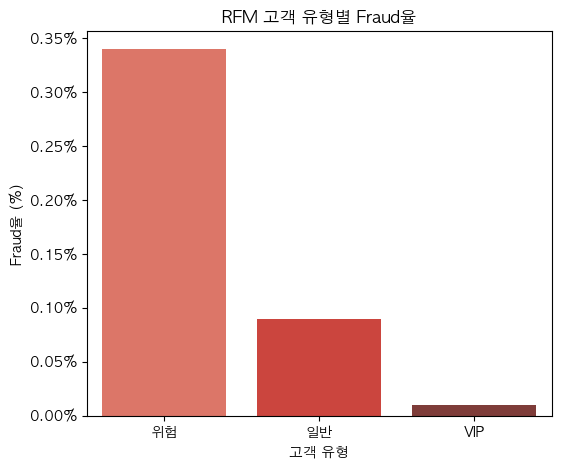

In [18]:
# RFM 세그먼트별 Fraud 집중도 
plt.figure(figsize=(6, 5))
sns.barplot(
    data=df_rfm_segment,
    x="customer_type",
    y="fraud_rate",
    palette="Reds_d"
)
plt.title("RFM 고객 유형별 Fraud율")
plt.xlabel("고객 유형")
plt.ylabel("Fraud율 (%)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}%"))
plt.show()

RFM 종합 점수로 나눈 고객군에서 위험 그룹의 Fraud율이 가장 높음(0.34%).

VIP 고객은 Fraud율이 거의 없음 → 실제 충성도가 높은 고객군은 Fraud 가능성이 낮다는 점을 확인.

Fraud 대응 관점에서는 “위험 그룹”을 우선 관리해야 함.

       type  total_txn  fraud_txn  fraud_rate  fraud_amount_rate
0  TRANSFER       9562       95.0        0.99               1.43
1  CASH_OUT      40741       76.0        0.19               1.27
2   CASH_IN      25514        0.0        0.00               0.00
3   PAYMENT      38441        0.0        0.00               0.00
4     DEBIT        699        0.0        0.00               0.00


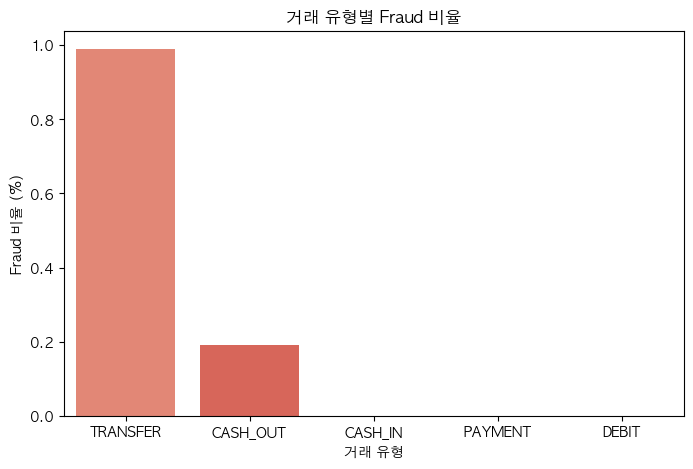

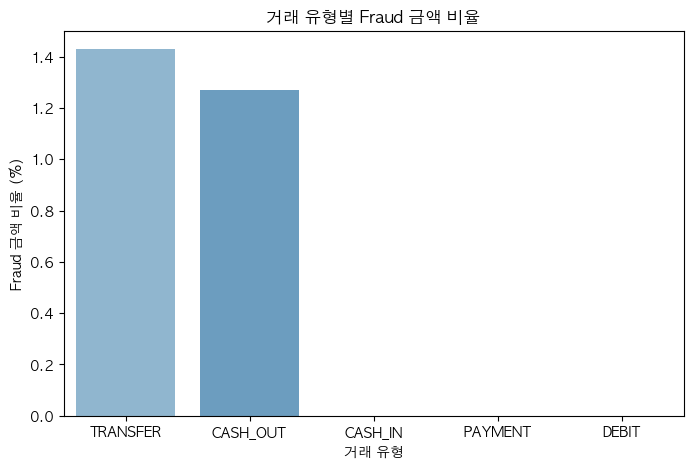

In [19]:
# 거래 유형별 Fraud 거래 비율
query_type_fraud = """
SELECT
    type,
    COUNT(*) AS total_txn,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) AS fraud_txn,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS fraud_rate,
    ROUND(100.0 * SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END)/SUM(amount), 2) AS fraud_amount_rate
FROM paysim
GROUP BY type
ORDER BY fraud_rate DESC;
"""

df_type_fraud = pd.read_sql(query_type_fraud, engine)
print(df_type_fraud)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=df_type_fraud, x="type", y="fraud_rate", palette="Reds_d")
plt.title("거래 유형별 Fraud 비율")
plt.xlabel("거래 유형")
plt.ylabel("Fraud 비율 (%)")
plt.show()

# 금액 비중도 같이 보려면
plt.figure(figsize=(8, 5))
sns.barplot(data=df_type_fraud, x="type", y="fraud_amount_rate", palette="Blues_d")
plt.title("거래 유형별 Fraud 금액 비율")
plt.xlabel("거래 유형")
plt.ylabel("Fraud 금액 비율 (%)")
plt.show()


Fraud는 **TRANSFER(이체)**와 CASH_OUT(출금) 유형에서 거의 전부 발생.

PAYMENT, CASH_IN, DEBIT 등에서는 Fraud가 거의 없음.

금융사기에서 흔히 나타나는 패턴으로, 이체 후 즉시 현금화 구조가 뚜렷하게 드러남.

금액 기준으로도 TRANSFER와 CASH_OUT이 Fraud 금액 대부분을 차지.

단순히 거래 수뿐 아니라 금액 규모 측면에서도 이 두 유형이 집중 위험군임.

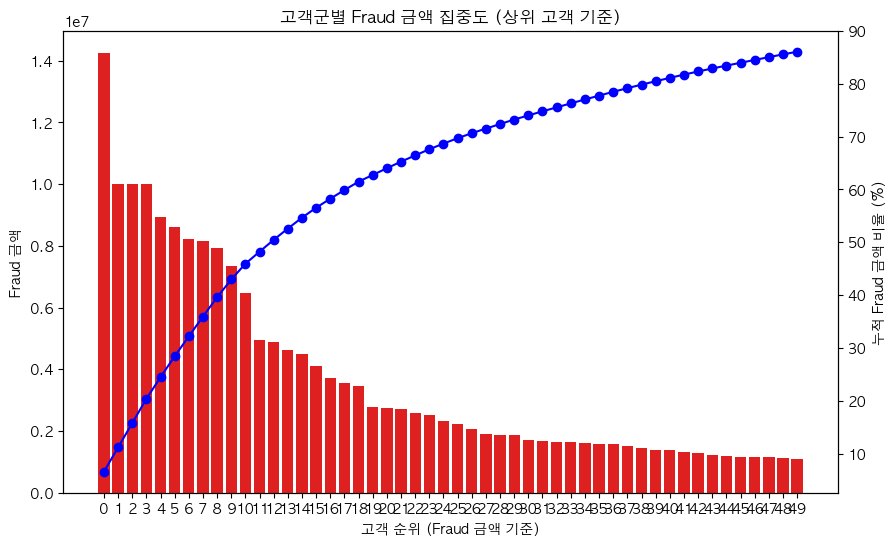

In [20]:
# RFM 세그먼트별 Fraud 금액 기여도 계산
query_rfm_contribution = """
WITH rfm_base AS (
    SELECT
        nameOrig AS customer_id,
        SUM(amount) AS monetary,
        SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END) AS fraud_amount
    FROM paysim
    GROUP BY nameOrig
)
SELECT
    customer_id,
    monetary,
    fraud_amount
FROM rfm_base
WHERE fraud_amount > 0
ORDER BY fraud_amount DESC;
"""

df_rfm_contribution = pd.read_sql(query_rfm_contribution, engine)

# 누적 기여도 계산
df_rfm_contribution["cum_fraud_amount"] = df_rfm_contribution["fraud_amount"].cumsum()
df_rfm_contribution["cum_fraud_amount_pct"] = (
    df_rfm_contribution["cum_fraud_amount"] / df_rfm_contribution["fraud_amount"].sum() * 100
)

# Pareto 차트
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_rfm_contribution.head(50),  # 상위 50 고객만 표시 (많으면 그래프 복잡해짐)
    x=df_rfm_contribution.head(50).index,
    y="fraud_amount",
    color="red"
)
plt.ylabel("Fraud 금액")
plt.xlabel("고객 순위 (Fraud 금액 기준)")
plt.title("고객군별 Fraud 금액 집중도 (상위 고객 기준)")

# 누적 기여도 라인
ax2 = plt.twinx()
ax2.plot(
    df_rfm_contribution.head(50).index,
    df_rfm_contribution.head(50)["cum_fraud_amount_pct"],
    color="blue",
    marker="o"
)
ax2.set_ylabel("누적 Fraud 금액 비율 (%)")

plt.show()


소수의 상위 고객군이 Fraud 금액의 대부분을 차지.

상위 10~20명 고객만으로 전체 Fraud 금액의 절반 이상이 발생.

Pareto 법칙 (20% 고객이 80% 위험 차지) 패턴이 보임 → 소수 고액 Fraud 고객에 대한 집중 관리 필요.